## Data Processing and Merging

### 1) Duplicate Removal
Based on how the GDELT data was loaded, there is a potential for duplicate entries. These will be removed as part of the data processing. 

In [1]:
#import necessary packages
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
#read the created GDELT dataset from the Data Load Notebook
df_complete = pd.read_pickle('df_complete.pickle')

In [ ]:
#sort dataframe by ADM1Code so that duplicate removal removes the less granular entry (e.g. in this case the country one)
df_complete = df_complete.sort_values("ActionGeo_ADM1Code", ascending = False)

In [ ]:
#next step is to remove duplicates by comparing all columns
df_complete = df_complete.drop_duplicates(
  subset = ['SQLDATE', 'MonthYear', 'Actor1Code', 'Actor2Code', 'EventCode', 'ActionGeo_ADM1Code'],
  keep = 'last').reset_index(drop = True)
len(df_complete)

In [ ]:
#GDELT DATA has entries for a country on two levels (e.g. BN and BN00) which needs to merged into one for all countries 
#condition
conditions = [df_complete['ActionGeo_ADM1Code']== 'BN',
             df_complete['ActionGeo_ADM1Code']== 'EK',
             df_complete['ActionGeo_ADM1Code']== 'GA',
             df_complete['ActionGeo_ADM1Code']== 'GH',
             df_complete['ActionGeo_ADM1Code']== 'GV',
             df_complete['ActionGeo_ADM1Code']== 'IV',
             df_complete['ActionGeo_ADM1Code']== 'LI',
             df_complete['ActionGeo_ADM1Code']== 'ML',
             df_complete['ActionGeo_ADM1Code']== 'MR',
             df_complete['ActionGeo_ADM1Code']== 'PU',
             df_complete['ActionGeo_ADM1Code']== 'SG',
             df_complete['ActionGeo_ADM1Code']== 'SL',
             df_complete['ActionGeo_ADM1Code']== 'TO',
             df_complete['ActionGeo_ADM1Code']== 'WI',
             df_complete['ActionGeo_ADM1Code']== 'UV',]

#values if condition are given
values = ['BN00','EK00','GA00','GH00','GV00','IV00','LI00','ML00','MR00', 'PU00',
        'SG00', 'SL00', 'TO00', 'WI00', 'UV00']

#replace value in original column
df_complete['ActionGeo_ADM1Code']=np.select(conditions, values, default = df_complete['ActionGeo_ADM1Code'])

In [ ]:
#also remove duplicates where event is recorded on both ADM1 and country level 
df_complete = df_complete.drop_duplicates(
  subset = ['SQLDATE', 'MonthYear', 'Actor1Code', 'Actor2Code', 'EventCode', 'GoldsteinScale', 'QuadClass', 'ActionGeo_CountryCode'],
  keep = 'last').reset_index(drop = True)
len(df_complete)

In [ ]:
#remove subdivisions that are not maintainted anymore (according to comparison to external ADM1 subdivisions)
adm1_to_remove = ['LI15', 'LI16','LI17','LI18', 'MR13', 'SG16', 'SG17', 'SG18']
df_complete.drop(df_complete[df_complete['ActionGeo_ADM1Code'].isin(adm1_to_remove)].index, inplace = True)

In [ ]:
#the resulting dataframe has this many entries 
len(df_complete)

### 2) Grouping and Extension
In order to be able to forecast the number of conflicts by state, month and year, a grouping of the dataframe by the same dimensions needs to be performed.
The decision was taken to work with the grouped dataset without the event code but there is also a potential to include the event code in future analyses. 

In [ ]:
#create grouped dataframes which sum up the number of events by the respective dimensions
df_grouped_witheventcode  = df_complete.groupby(['MonthYear', 'EventCode', 'ActionGeo_CountryCode', 'ActionGeo_ADM1Code']).size().reset_index(name='number of conflicts')#
df_grouped  = df_complete.groupby(['MonthYear', 'Year', 'ActionGeo_CountryCode', 'ActionGeo_ADM1Code']).size().reset_index(name='number of conflicts')

In [ ]:
len(df_grouped)

GDELT data only contains data on conflicts that happened. Therefore, data needs to be added for the intersection of states, months and years for which 0 conflicts have been recorded.

In [ ]:
#create lists of the complete MonthYears and States have been created 
all_available_states = list(pd.read_excel("CompleteStatesAndMonthYears.xlsx", sheet_name = "States")['ADM1'])
all_available_yearmonths = list(pd.read_excel("CompleteStatesAndMonthYears.xlsx", sheet_name = "MonthYear")['MonthYear'])

In [ ]:
#an empty dataframe is created in which all missing intersections will be written with 0 conflicts
missing_intersection = pd.DataFrame(columns = ['MonthYear', 'Year', 'ActionGeo_CountryCode', 'ActionGeo_ADM1Code',
       'number of conflicts'])

df_filtered = pd.DataFrame()
for state in all_available_states:
    for date in all_available_yearmonths:
        del df_filtered
        df_filtered = df_grouped[(df_grouped['ActionGeo_ADM1Code']==state)
                       & (df_grouped['MonthYear']==date)]
        if len(df_filtered) == 0: 
            additional_entries = []
            additional_entries = [date, str(date)[0:4], [state[i:i + 2] for i in range(0, len(state), 2)][0], state, 0]
            missing_intersection.loc[len(missing_intersection)] = additional_entries
        else: 
            continue
            

In [ ]:
len(df_grouped), len(missing_intersection)

In [ ]:
#concat grouped dataframe with missing intersection to receive complete dataset
df_complete2 = pd.concat([df_grouped, missing_intersection], axis=0)
len(df_complete2)

In [ ]:
#export dataset for immediate processing
df_complete2.to_pickle(path = "df_complete2_extended.pickle")

In [2]:
#import dataset for immediate processing
df_complete2 = pd.read_pickle("df_complete2_extended.pickle")

In [3]:
#take a look at the length of the dataset
len(df_complete2)

102444

In [4]:
#remove all entries prior to 1982 as these are irrelevant for further processing
df_complete2 = df_complete2[df_complete2["MonthYear"] != 192001]

### 3) Additional Predictors
Now that we have the raw GDELT data in the format of number of conflicts per month and state, we join additional predictors, the HDI and WBI in this case. 

**HDI Data**

The nomenclature of the HDI dataset is different from the GDELT data in regards to the states and years, so in a first step we write down the iso_codes for the relevant countries and filter the dataset accordingly. 

In [5]:
#define all relevant countries 
relevant_countries = ["BEN", "GNQ", "GMB", "GHA", "GIN", "CIV", "LBR", "MLI", "MRT", "GNB", "SEN", "SLE", "TGO", "BFA"]

In [6]:
#reading the hdi data for the respective countries
country_hdi_data=pd.read_excel('SHDI-SGDI-Total 5.0 (1).xlsx', sheet_name=0)
country_hdi_data=country_hdi_data[country_hdi_data['iso_code'].isin(relevant_countries)]

In [7]:
#checking the length of the hdi dataset
len(country_hdi_data)

3946

In [8]:
#as states and countries have a different nomenclature, a manual match between the states has been performed and recorded
#in the excel file below which gets read into a dataframe
matched_states = pd.read_excel('states_markup.xlsx', sheet_name = "Final")

In [9]:
matched_states.head()

,adm1,country,region,iso_code
0,BN00,BN,Total,BEN
1,BN01,BN,Atacora (incl Donga),BEN
2,BN02,BN,Atlantique (incl Littoral (Cotonou)),BEN
3,BN03,BN,Borgou (incl Alibori),BEN
4,BN04,BN,Mono (incl Couffo),BEN


In [11]:
#for later processing, the country and adm1 description of the GDELT dataset is added to the HDI data 
#NOTE: as there is no 1:1 match between the states, the length of the dataset increases 
new_hdi = country_hdi_data.merge(matched_states, on=['iso_code', 'region'], how = 'left')

In [12]:
len(new_hdi)

6995

In [13]:
#next, we drop some columns and rename the kept ones
#NOTE: some of the categorical columns are erased + indicators which are separated in male and female again
new_hdi.drop(columns = ['GDLCODE', 'continent',
                               'shdif', 'shdim','healthindexf', 'healthindexm',
                               'incindexf', 'incindexm','edindexf', 'edindexm',
                               'eschf', 'eschm','mschf', 'mschm', 'lifexpf',
                               'lifexpm', 'gnic', 'gnicf', 'gnicm','lgnicf', 'lgnicm',
                               'mfsel'], inplace = True)

new_hdi.rename(columns={"pop": "population (000'000)", "lgnic": "GNI per capita (000'000)", 
                                      "msch": "mean years of scholing", "esch": "expected years of schooling", 
                                      "lifexp": "life expectancy", "incindex": "income index", 
                                      "edindex": "educational index", "healthindex": "health index", 
                                      "shdi": "human development index (HDI)", "sgdi": "gender development index (GDI)"},
                             inplace = True)

new_hdi.dtypes

iso_code                           object
country_x                          object
year                                int64
level                              object
region                             object
gender development index (GDI)     object
human development index (HDI)     float64
health index                      float64
income index                      float64
educational index                 float64
expected years of schooling       float64
mean years of scholing            float64
life expectancy                   float64
GNI per capita (000'000)          float64
population (000'000)               object
adm1                               object
country_y                          object
dtype: object

In [14]:
#gender development index is in an incorrect type format, so we update it 
new_hdi['gender development index (GDI)'] = pd.to_numeric(new_hdi['gender development index (GDI)'], errors='coerce')
new_hdi.dtypes

iso_code                           object
country_x                          object
year                                int64
level                              object
region                             object
gender development index (GDI)    float64
human development index (HDI)     float64
health index                      float64
income index                      float64
educational index                 float64
expected years of schooling       float64
mean years of scholing            float64
life expectancy                   float64
GNI per capita (000'000)          float64
population (000'000)               object
adm1                               object
country_y                          object
dtype: object

In [15]:
#we check the minimum and maximum year of the HDI dataset which reveals that the time span covered is shorter compared
#to the GDELT dataset
print(min(new_hdi['year']), max(new_hdi['year']))

1990 2019


For the below special cases, no direct mapping of states was possible. Instead, an average of multiple states is required or th national total value is kept in case no match at all was identifiable.

In [16]:
# special case for EK02 
ek = new_hdi[new_hdi['iso_code'] == "GNQ"]
ek = ek[(ek["region"] != "Annobon, Bioko") & (ek['level'] == "Subnat")]
ek02 = ek.groupby(['year']).mean().reset_index()
ek02.head(2)

,year,gender development index (GDI),human development index (HDI),health index,income index,educational index,expected years of schooling,mean years of scholing,life expectancy,GNI per capita (000'000)
0,2000,NaN,0.47650,0.5120,0.643,0.33125,6.5915,4.4495,53.27350,8.8600
1,2001,NaN,0.48575,0.5165,0.666,0.33575,6.7565,4.4495,53.57325,9.0145


In [17]:
ek02['level'] = "Subnat"
ek02['iso_code'] = "GNQ"
ek02['adm1'] = "EK02"
ek02['country_y'] = "EK"

In [18]:
len(ek02), len(new_hdi)

(20, 6995)

In [19]:
#add the special case EK02 to the HDI dataset
new_hdi = pd.concat([new_hdi, ek02])

In [20]:
ek02.shape, new_hdi.shape

((20, 14), (7015, 17))

In [21]:
# special case for SG02 
sg = new_hdi[new_hdi['iso_code'] == "SEN"]
sg02_regions = ["Ziguinchor", "Kolda"]
sg02 = sg[(sg["region"].isin(sg02_regions)) & (sg['level'] == "Subnat")]
sg02 = sg02.groupby(['year']).mean().reset_index() 

In [22]:
sg02['level'] = "Subnat"
sg02['iso_code'] = "SEN"
sg02['adm1'] = "SG02"
sg02['country_y'] = "SG"
#add the special case SG02 to the HDI dataset
new_hdi = pd.concat([new_hdi, sg02])

In [23]:
len(sg02), len(new_hdi)

(30, 7045)

In [24]:
# special case for SG15
sg15 = sg[sg['level'] == "Subnat"]
sg15 = sg15.groupby(['year']).mean().reset_index()

In [25]:
sg15['level'] = "Subnat"
sg15['iso_code'] = "SEN"
sg15['adm1'] = "SG15"
sg15['country_y'] = "SG"
#add the special case SG15 to the HDI dataset
new_hdi = pd.concat([new_hdi, sg15])

In [26]:
len(sg15), len(new_hdi)

(30, 7075)

In [27]:
#delete subnational for Guinea (GV), Cote D'Ivoire (IV), Sierra Leone (SL), Burkina Faso (UV). total values will be used
# as no mapping on state level was possible
new_hdi.drop(new_hdi[(new_hdi['iso_code'] == "GIN") & (new_hdi['level'] == "Subnat")].index, inplace = True)
new_hdi.drop(new_hdi[(new_hdi['iso_code'] == "SLE") & (new_hdi['level'] == "Subnat")].index, inplace = True)
new_hdi.drop(new_hdi[(new_hdi['iso_code'] == "CIV") & (new_hdi['level'] == "Subnat")].index, inplace = True)
new_hdi.drop(new_hdi[(new_hdi['iso_code'] == "BFA") & (new_hdi['level'] == "Subnat")].index, inplace = True)

In [28]:
new_hdi.shape, df_complete2.shape

((5855, 17), (102412, 5))

In [29]:
#ensure that year type is correct for the merge
df_complete2["Year"] = df_complete2["Year"].astype(int)

In [30]:
df_complete2

,MonthYear,Year,ActionGeo_CountryCode,ActionGeo_ADM1Code,number of conflicts
32,198201,1982,GH,GH00,14
33,198201,1982,GH,GH01,23
34,198201,1982,GH,GH02,5
35,198201,1982,LI,LI00,2
36,198201,1982,ML,ML00,2
...,...,...,...,...,...
81773,201807,2018,UV,UV91,0
81774,201907,2019,UV,UV91,0
81775,202007,2020,UV,UV91,0
81776,202107,2021,UV,UV91,0


In [31]:
#add the HDI data to the complete dataset by performing a left join on year and adm1code
test_df = pd.merge(df_complete2, new_hdi,  how='left', left_on=["Year", "ActionGeo_ADM1Code"], right_on = ["year", "adm1"])


**World Bank Indicators**

World Development Indicators (WDI) is the primary World Bank collection of development indicators, compiled from officially recognized international sources, it forms a compilation of international statistics on global development.

In [32]:
#loading the WBI data for each country and merging the data in the correct format into a dataframe
available_files = ['API_BEN_DS2_en_excel_v2_4363258.xls', 'API_BFA_DS2_en_excel_v2_4339316.xls',
'API_CIV_DS2_en_excel_v2_4324130.xls', 'API_GHA_DS2_en_excel_v2_4320378.xls',
'API_GIN_DS2_en_excel_v2_4364647.xls', 'API_GMB_DS2_en_excel_v2_4331096.xls',
'API_GNB_DS2_en_excel_v2_4346479.xls', 'API_GNQ_DS2_en_excel_v2_4346476.xls',
'API_LBR_DS2_en_excel_v2_4346179.xls', 'API_MLI_DS2_en_excel_v2_4318686.xls',
'API_MRT_DS2_en_excel_v2_4322231.xls', 'API_SEN_DS2_en_excel_v2_4347087.xls',
'API_SLE_DS2_en_excel_v2_4346481.xls', 'API_TGO_DS2_en_excel_v2_4346620.xls']

#now only using a subset of the predictors. potential to extend this list
useful_predictors = ["SL.UEM.TOTL.MA.ZS", "SL.UEM.TOTL.ZS","SL.UEM.TOTL.FE.ZS","SL.EMP.TOTL.SP.ZS","EG.CFT.ACCS.ZS",
                        "EG.ELC.ACCS.ZS","FP.CPI.TOTL","NY.GDP.MKTP.KD","NY.GDP.PCAP.KD","NY.GDP.PETR.RT.ZS",
                        "SM.POP.REFG","SP.RUR.TOTL.ZS"]

list1 = list(range(1982, 2022))
list2 = list(map(str, list1))

df_temp = pd.DataFrame()

for files in available_files: 
    country_wbi =pd.read_excel(files, skiprows = 3)
    
    country_wbi.drop(country_wbi.iloc[:, 4:26],axis = 1, inplace = True)
    country_wbi = country_wbi[country_wbi['Indicator Code'].isin(useful_predictors)]

    country_wbi.reset_index(drop=True, inplace=True)

    country_name = country_wbi['Country Code'][0]
    country_wbi.drop(columns = ['Country Name', 'Country Code', 'Indicator Code'], inplace = True)

    country_wbi_new = pd.melt(country_wbi, id_vars='Indicator Name', value_vars= list2,
                              var_name='year', value_name='amount')

    country_wbi_new['Country Code'] = country_name
    
    df_temp = pd.concat([df_temp, country_wbi_new])
    
    country_wbi = pd.DataFrame()
    countri_wbi_new = pd.DataFrame()
    
df_temp = df_temp.reset_index(drop=True)

df_grouped = df_temp.groupby(["Country Code", "Indicator Name"]).mean()
df_grouped.reset_index(inplace = True)

for index, row in df_temp.iterrows(): 
    if pd.isna(row['amount']) == True: 
        df_temp.at[index, 'amount'] = df_grouped[(df_grouped['Country Code'] == row['Country Code']) & (df_grouped['Indicator Name'] == row['Indicator Name'])]['amount']
    else:
        continue

In [33]:
countries = list(set(df_temp['Country Code']))
df_wbi_final = pd.DataFrame()
for country in countries: 
    df_filtered = df_temp[df_temp['Country Code'] == country]
    df_wbi_temp2 = pd.pivot(df_filtered, index = 'year', columns = 'Indicator Name', values = 'amount')
    
    df_wbi_temp2['Country Code'] = country
    df_wbi_final = pd.concat([df_wbi_final, df_wbi_temp2])   
    
    df_wbi_temp2 = pd.DataFrame()
    df_filtered = pd.DataFrame()
    
df_wbi_final.reset_index()
df_wbi_final

Indicator Name,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Consumer price index (2010 = 100),"Employment to population ratio, 15+, total (%) (modeled ILO estimate)",GDP (constant 2015 US$),GDP per capita (constant 2015 US$),Oil rents (% of GDP),Refugee population by country or territory of asylum,Rural population (% of total population),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Country Code
year,,,,,,,,,,,,,
1982,1.152381,14.680897,69.858202,67.273226,4.941037e+08,609.702019,0.0,8800.53125,79.987,7.038645,5.415355,6.180968,GNB
1983,1.152381,14.680897,69.858202,67.273226,4.773127e+08,574.928657,0.0,8800.53125,78.806,7.038645,5.415355,6.180968,GNB
1984,1.152381,14.680897,69.858202,67.273226,5.207921e+08,611.778255,0.0,8800.53125,77.574,7.038645,5.415355,6.180968,GNB
1985,1.152381,14.680897,69.858202,67.273226,5.424909e+08,622.006338,0.0,8800.53125,76.296,7.038645,5.415355,6.180968,GNB
1986,1.152381,14.680897,69.858202,67.273226,5.381844e+08,602.987421,0.0,8800.53125,74.966,7.038645,5.415355,6.180968,GNB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,0.900000,34.779999,110.229263,64.035004,1.460765e+10,789.072631,0.0,17036.00000,58.428,8.386000,6.687000,7.410000,MLI
2018,0.900000,50.900002,110.559451,63.983002,1.530100e+10,802.033621,0.0,26538.00000,57.644,8.403000,6.705000,7.428000,MLI
2019,0.900000,47.836277,108.726080,63.918999,1.602874e+10,815.379101,0.0,26672.00000,56.864,8.414000,6.720000,7.442000,MLI


In [34]:
#export to excel for testing
df_wbi_final.to_excel("df_wbi_final.xlsx")

In [35]:
#need to check if 2021 data is available for all countries, in that case forecast only for 2022
df_wbi_final_test = df_wbi_final.reset_index()
df_wbi_final_test[df_wbi_final_test["year"] == "2021"]

Indicator Name,year,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Consumer price index (2010 = 100),"Employment to population ratio, 15+, total (%) (modeled ILO estimate)",GDP (constant 2015 US$),GDP per capita (constant 2015 US$),Oil rents (% of GDP),Refugee population by country or territory of asylum,Rural population (% of total population),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Country Code
39,2021,1.152381,14.680897,69.858202,66.037003,1.265073e+09,627.675020,0.000000,1846.0,55.383,7.694,5.932,6.759,GNB
79,2021,0.452381,12.451786,104.172660,71.669998,3.240179e+09,625.492033,0.000000,8169.0,47.427,3.365,4.739,4.095,LBR
119,2021,3.142857,29.255348,116.044206,69.830002,1.569745e+10,1260.734609,0.530840,1736.0,51.028,1.860,1.295,1.574,BEN
159,2021,32.359524,47.738296,80.244155,42.876999,2.424600e+10,1409.953856,0.000252,14479.0,51.400,3.997,3.544,3.723,SEN
199,2021,22.297619,65.893630,71.802009,49.854000,9.534008e+09,6575.672189,21.880515,NaN,26.439,10.609,8.419,9.245,GNQ
239,2021,20.733333,55.635514,118.991106,53.574001,6.531937e+10,2414.440339,0.967656,4349.0,47.820,4.144,2.999,3.468,CIV
279,2021,0.411905,15.661907,297.185330,53.019001,5.128555e+09,629.939682,0.000000,345.0,56.628,4.650,6.023,5.333,SLE
319,2021,4.130952,33.871515,74.763121,55.111000,5.460540e+09,644.065112,0.000000,10683.0,56.642,3.114,4.852,4.004,TGO
359,2021,2.709524,39.431974,196.461489,50.965000,1.768338e+09,711.050403,0.000000,4418.0,36.778,14.820,8.430,11.212,GMB
399,2021,39.757143,32.948903,71.657125,39.612999,7.372519e+09,1543.947556,1.033768,101942.0,43.867,13.004,10.780,11.463,MRT


In [36]:
#check if any entries are not present 
df_wbi_final_test.isnull().sum()

Indicator Name
year                                                                      0
Access to clean fuels and technologies for cooking (% of population)      0
Access to electricity (% of population)                                   0
Consumer price index (2010 = 100)                                         0
Employment to population ratio, 15+, total (%) (modeled ILO estimate)     0
GDP (constant 2015 US$)                                                   0
GDP per capita (constant 2015 US$)                                        0
Oil rents (% of GDP)                                                      0
Refugee population by country or territory of asylum                     40
Rural population (% of total population)                                  0
Unemployment, female (% of female labor force) (modeled ILO estimate)     0
Unemployment, male (% of male labor force) (modeled ILO estimate)         0
Unemployment, total (% of total labor force) (modeled ILO estimate)      

In [37]:
#calculate averages and impute missing values wit averages
#missing values are only present for country GNQ Refugee Population. as no values at all are available, this gets replaced with 0. 
df_wbi_final.fillna(0, inplace = True)

In [38]:
df_wbi_final.columns

Index(['Access to clean fuels and technologies for cooking (% of population)',
       'Access to electricity (% of population)',
       'Consumer price index (2010 = 100)',
       'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
       'GDP (constant 2015 US$)', 'GDP per capita (constant 2015 US$)',
       'Oil rents (% of GDP)',
       'Refugee population by country or territory of asylum',
       'Rural population (% of total population)',
       'Unemployment, female (% of female labor force) (modeled ILO estimate)',
       'Unemployment, male (% of male labor force) (modeled ILO estimate)',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)',
       'Country Code'],
      dtype='object', name='Indicator Name')

In [39]:
predictors = list(df_wbi_final.columns)

In [40]:
predictors.remove("Country Code")

**World Bank Indicators Forecast**

WBI Indicators are only present until 2020 and need to be forecasted for 2021 and 2022. This predictor forecasting approach is verified in a separate notebook, called "AutoRegressor Approach Verification". 

In [42]:
predictors

['Access to clean fuels and technologies for cooking (% of population)',
 'Access to electricity (% of population)',
 'Consumer price index (2010 = 100)',
 'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
 'GDP (constant 2015 US$)',
 'GDP per capita (constant 2015 US$)',
 'Oil rents (% of GDP)',
 'Refugee population by country or territory of asylum',
 'Rural population (% of total population)',
 'Unemployment, female (% of female labor force) (modeled ILO estimate)',
 'Unemployment, male (% of male labor force) (modeled ILO estimate)',
 'Unemployment, total (% of total labor force) (modeled ILO estimate)']

In [43]:
#forecasting of the values 
df_wbi_final_copy = df_wbi_final.copy()
#define necessary lists
country_codes = set(df_wbi_final["Country Code"])
year_list3 = [2022]
# for the time series forecasting, the date dimension needs to be the idnex
df_wbi_final = df_wbi_final.sort_index()

In [44]:
#export the data to verify the chosen forecasting approach
df_wbi_final.to_excel("autoreg_test_wbi.xlsx")

In [ ]:
#define a function to create predictions for the next year
def create_predictions(data, columns, States, year_list):
    df_pred = pd.DataFrame()
    df_new = pd.DataFrame()
    df = pd.DataFrame()
    steps = len(year_list)
     
    for j in States: 
        data_filtered = data[data['Country Code'] == j]
        data_filtered.drop(columns = ['Country Code'], inplace = True)
        data_train = data_filtered
        
        for i in columns: 
            forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123), lags = 15)
            
            forecaster.fit(y=data_train[i])
            
            predictions = forecaster.predict(steps = steps)
            predictions.to_frame()
            df_pred[i] = predictions
            df_pred['Country Code'] = j
            df_pred['year'] = year_list
        df_new = df_new.append(df_pred)
    df = df.append(df_new)
   
    return df

In [ ]:
#call the prediction function and let it run for the coming year
df = create_predictions(df_wbi_final, predictors, country_codes, year_list3)

In [ ]:
df_wbi_final_copy = df_wbi_final.reset_index()

In [ ]:
#merge the forecasted data to the previous dataset
df_new = pd.concat([df_wbi_final_copy, df], axis = 0)

df_new_copy = df_new.copy()
df_new

In [ ]:
#export file for immediate processing
df_new.to_pickle("df_new.pickle")

In [ ]:
#import file for immediate processing
import pandas as pd
df_wbi = pd.read_pickle("df_new.pickle")

**HDI Forecast**

HDI Data is only available until 2019. Future values will be forecasted while past values, so values prior to 1990, will be imputed with the average. This predictor forecasting approach for future values is verified in a separate notebook, called "AutoRegressor Approach Verification". 

In [45]:
#type of this column needs to be changed
test_df["population (000'000)"] = test_df["population (000'000)"].astype(float)

In [46]:
all_columns = ['MonthYear', 'Year', 'ActionGeo_CountryCode', 'ActionGeo_ADM1Code',
       'number of conflicts', 'iso_code', 'country_x', 'e year', 'level',
       'region', 'gender development index (GDI)',
       'human development index (HDI)', 'health index', 'income index',
       'educational index', 'expected years of schooling',
       'mean years of scholing', 'life expectancy', "GNI per capita (000'000)",
       "population (000'000)", 'adm1', 'country_y']

In [47]:
#split dataset into two parts, future and past. As the NaN values will be treated differently depending on that. 
test_df_future = test_df[test_df["Year"] > 2019 ]
test_df_past = test_df[test_df["Year"] <= 2019 ]

In [49]:
#get all countries and write them into a list
countries = test_df_past['ActionGeo_CountryCode'].apply(pd.Series).stack().reset_index(drop=True).drop_duplicates()
countries

0      GH
3      LI
4      ML
5      SG
7      EK
8      GA
10     GV
11     IV
14     MR
16     WI
19     TO
31     SL
59     UV
60     BN
167    PU
dtype: object

The HDI data does not start in the same year for every Country. Therefore, the missing values exist for different combinations of MonthYears and States. The missing values of the past will be replaced by the average for that specific region. 

In [50]:
#calculate the mean per state for each numeric column
grouped_df_adm1 = test_df_past.groupby(["ActionGeo_ADM1Code"]).mean()
grouped_df_adm1.drop(columns = ["Year", "year"], inplace = True)
grouped_df_adm1 = grouped_df_adm1.fillna(0)
grouped_df_adm1 = grouped_df_adm1.reset_index()

In [51]:
grouped_df_adm1

,ActionGeo_ADM1Code,MonthYear,number of conflicts,gender development index (GDI),human development index (HDI),health index,income index,educational index,expected years of schooling,mean years of scholing,life expectancy,GNI per capita (000'000),population (000'000)
0,BN00,200056.5,39.010965,0.832833,0.455367,0.577300,0.489933,0.340000,8.990000,2.706667,57.523333,7.8489,8050.199000
1,BN01,200056.5,0.000000,0.822583,0.396333,0.555967,0.451433,0.254900,7.497100,1.401967,56.139667,7.5935,1162.139100
2,BN02,200056.5,0.000000,0.844833,0.547333,0.602433,0.556900,0.493900,11.333867,5.370867,59.156267,8.2915,1627.724367
3,BN03,200056.5,0.000000,0.849250,0.387667,0.576700,0.467300,0.219967,6.110500,1.506667,57.485800,7.6996,1543.876467
4,BN04,200056.5,0.000000,0.808583,0.445233,0.580367,0.454033,0.345467,10.070200,1.973967,57.722833,7.6105,1011.579400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,UV88,200056.5,0.657895,0.852909,0.373850,0.559450,0.424750,0.222700,6.360000,1.380000,56.360000,7.4169,15590.256700
201,UV89,200056.5,0.217105,0.852909,0.373850,0.559450,0.424750,0.222700,6.360000,1.380000,56.360000,7.4169,15590.256700
202,UV90,200056.5,3.798246,0.852909,0.373850,0.559450,0.424750,0.222700,6.360000,1.380000,56.360000,7.4169,15590.256700
203,UV91,200056.5,0.109649,0.852909,0.373850,0.559450,0.424750,0.222700,6.360000,1.380000,56.360000,7.4169,15590.256700


In [52]:
#drop unnecessary columns
test_df_past.drop(columns = ['iso_code', 'country_x', 'year', 'adm1', 'country_y'], inplace = True )
test_df_future.drop(columns = ['iso_code', 'country_x', 'year', 'adm1', 'country_y'], inplace = True )

C:\Users\Shadow\AppData\Local\Temp\ipykernel_7456\2038215063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_past.drop(columns = ['iso_code', 'country_x', 'year', 'adm1', 'country_y'], inplace = True )
C:\Users\Shadow\AppData\Local\Temp\ipykernel_7456\2038215063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_future.drop(columns = ['iso_code', 'country_x', 'year', 'adm1', 'country_y'], inplace = True )


In [53]:
#write all numeric columns into a list
numeric_columns = ['gender development index (GDI)', 'human development index (HDI)',
       'health index', 'income index', 'educational index',
       'expected years of schooling', 'mean years of scholing',
       'life expectancy', "GNI per capita (000'000)", "population (000'000)"]

In [54]:
#fill Nan values for the past data with the average of the state
for index, row in test_df_past.iterrows():
    for column in numeric_columns:    
        if pd.isna(row[column]) == True:
            test_df_past.at[index, column] = grouped_df_adm1[grouped_df_adm1["ActionGeo_ADM1Code"] == row["ActionGeo_ADM1Code"]][column]
        else: 
            continue

In [55]:
#check that no NaNs remain ---- NA comes from LEVEL/REGION field which are not populated
test_df_past.isna().sum().sum()
#test_df_past["income index"].isna().sum().sum()

57352

In [56]:
len(test_df_past)

98408

In [57]:
#in the last step, we remove any available duplicates by comparing all columns
test_df_past.drop_duplicates(inplace = True)

C:\Users\Shadow\AppData\Local\Temp\ipykernel_7456\3905887967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_past.drop_duplicates(inplace = True)


In [58]:
len(test_df_past)

93480

Now we take care of the future values that are missing (starting at 2019). 

In [60]:
#write lists for forecasted values 
adm1 = set(test_df_future["ActionGeo_ADM1Code"])
year_list1 = [202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012]
year_list2 = [202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108, 202109, 202110, 202111, 202112]
year_list3 = [202201, 202202, 202203, 202204, 202205, 202206, 202207, 202208]

In [61]:
# for the time series forecasting, the date dimension needs to be the idnex
test_df_past['MonthYear_2'] = test_df_past['MonthYear']
test_df_past = test_df_past.set_index('MonthYear_2')
test_df_past = test_df_past.sort_index()

C:\Users\Shadow\AppData\Local\Temp\ipykernel_7456\1269219251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_past['MonthYear_2'] = test_df_past['MonthYear']


In [62]:
#we save a copy of the dataframe which we will later on merge with the forecasted data
test_df_past_copy = test_df_past.copy()

In [63]:
len(test_df_past), len(test_df_past_copy)

(93480, 93480)

In [67]:
#exporting the data to excel file for the approach verification notebook
test_df_past.to_excel("autoreg_hdi.xlsx")

In [65]:
#define a function to create predictions for the next year
def create_predictions(data, predictors, States, year_list):
    df_pred = pd.DataFrame()
    df_new = pd.DataFrame()
    df = pd.DataFrame()
    steps = len(year_list)
     
    for j in States: 
        data_filtered = data[data['ActionGeo_ADM1Code'] == j]
        data_filtered.drop(columns = [#"Year", "ActionGeo_CountryCode",
            "ActionGeo_ADM1Code",

                                     ], inplace = True)
        data_train = data_filtered
        
        for i in predictors: 
            forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123), lags = 62)
            
            forecaster.fit(y=data_train[i])
            
            predictions = forecaster.predict(steps = steps)
            predictions.to_frame()
            df_pred[i] = predictions
            df_pred['ActionGeo_ADM1Code'] = j
            df_pred['MonthYear'] = year_list
        df_new = df_new.append(df_pred)
    df = df.append(df_new)
   
    return df

#call the prediction function and let it run for the coming year
#df = create_predictions(test_df_past, numeric_columns, adm1, year_list1)

In [66]:
#call the prediction function and let it run for the coming year
df = create_predictions(test_df_past, numeric_columns, adm1, year_list1)

C:\Users\Shadow\AppData\Local\Temp\ipykernel_7456\2839625428.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.drop(columns = [#"Year", "ActionGeo_CountryCode",
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Us

C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index i

C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index i

C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index i

C:\Users\Shadow\AppData\Local\Temp\ipykernel_7456\2839625428.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df_pred)
C:\Users\Shadow\AppData\Local\Temp\ipykernel_7456\2839625428.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.drop(columns = [#"Year", "ActionGeo_CountryCode",
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Shadow\AppData\Roaming\Python\Python39\site-packages\skforecast\utils\utils.py:256: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeInde

KeyboardInterrupt: 

In [ ]:
#merge the old dataset with the forecasted values
df_new = pd.DataFrame()
df_new = pd.concat([test_df_past, df], axis = 0)

In [ ]:
df_new_copy = df_new.copy()

df_new = df_new.set_index('MonthYear')
df_new = df_new.sort_index()
df_new

df_new_copy.drop(columns = ['Year', 'ActionGeo_CountryCode', 'level', 'region', 'number of conflicts'], inplace = True)

In [ ]:
df_new.drop(columns = ['number of conflicts'], inplace = True)

In [ ]:
#redo the forecasting for the 2nd year
df2 = create_predictions(df_new, numeric_columns, adm1, year_list2)

In [ ]:
#add the forescasted values for 2021 to the previous dataset
df2_copy = df2.copy()

df_new = pd.concat([df_new_copy, df2], axis = 0)

In [ ]:
#create a copy of the new dataset
df_new_copy2 = df_new.copy()

In [ ]:
#set MonthYear column as the index and sort the data accordingly 
df_new = df_new.set_index('MonthYear')
df_new = df_new.sort_index()
df_new

In [ ]:
#redo the forecasting for the 3rd year
df3 = create_predictions(df_new, numeric_columns, adm1, year_list3)

In [ ]:
#check that no NaNs remain in the created dataframe
df3.isna().sum().sum()

In [ ]:
#concatenate old dataset and newly forecasted values for 2022
df_new = pd.concat([df_new_copy2, df3], axis = 0)
df_new = df_new.reset_index(drop = True)

In [ ]:
df_new_copy_final = df_new.copy()

In [ ]:
df_new

In [ ]:
#rejoin number of conflicts, ActionGeo_CountryCode to the df_new dataframe
#test_df.drop(columns = ['iso_code', 'country_x', 'year', 'level',
#       'region', 'gender development index (GDI)',
#       'human development index (HDI)', 'health index', 'income index',
#       'educational index', 'expected years of schooling',
#       'mean years of scholing', 'life expectancy', "GNI per capita (000'000)",
#       "population (000'000)", 'adm1', 'country_y'], inplace = True)

In [ ]:
#add the new HDI values to the other dataset
merged = df_new.merge(test_df, how ="left", left_on = ['MonthYear', 'ActionGeo_ADM1Code'], right_on = ['MonthYear', 'ActionGeo_ADM1Code'])

In [ ]:
len(df_new), len(test_df), len(merged)

In [ ]:
#drop any existing duplicate entries by comparing all columns
merged.drop_duplicates(inplace = True)

In [ ]:
#need to add the country codes via the iso codes to the WBI dataset
matched_states_subset = matched_states[['country', 'iso_code']]
matched_states_subset.drop_duplicates(inplace = True)

df_wbi_with_code = pd.merge(df_wbi, matched_states_subset, how = "left", left_on = ['Country Code'], right_on = ['iso_code'])

In [ ]:
#change the year type to int to enable a correct merge (both columns need to be of the same type)
df_wbi_with_code['year'] = df_wbi_with_code['year'].astype(int)

In [ ]:
#merge the WBI data with the previously merged dataset
merged_2 = pd.merge(merged, df_wbi_with_code, how ="left", left_on = ['Year', 'ActionGeo_CountryCode'], right_on = ['year', 'country'])

In [ ]:
#verify that the length of the datasets have not changed after adding additional columns
len(merged), len(merged_2)

In [ ]:
#check for missing values, and upon closer inspection we find out that values are missing for Western Sahara
#as there were no WBI for this country
merged_2.isna().sum()

In [ ]:
#the following constants will be imputed for missing values for Western Sahara
merged_2['year'] = merged_2['Year']
merged_2['Country Code'] = merged_2['Country Code'].fillna('ESH')
merged_2['country'] = merged_2['ActionGeo_CountryCode']
merged_2['iso_code'] = merged_2['iso_code'].fillna('ESH')

#all numeric values will be filled with NA
merged_2 = merged_2.fillna(0)

In [ ]:
#ensure that there are no more missing values
merged_2.isna().sum()

In [ ]:
#export the final dataframe which includes GDELT data as well as the HDI and WBI predictors so that it can be used in 
#the following notebook
merged_2.to_pickle("merged_2.pickle")

In [2]:
#import dataframe which has the merged GDELT, HDI AND WDI data
import pandas as pd
df_complete = pd.read_pickle("merged_2.pickle")

In [3]:
#check that no NaNs remain as the Deep Learning model cannot handle missing datapoints
df_complete.isna().sum().sum()

0

In [4]:
#check the length of the dataframe
len(df_complete)

100040

In [5]:
#let's have a look at the data
df_complete.head(5)

,MonthYear,ActionGeo_ADM1Code,gender development index (GDI),human development index (HDI),health index,income index,educational index,expected years of schooling,mean years of scholing,life expectancy,...,GDP per capita (constant 2015 US$),Oil rents (% of GDP),Refugee population by country or territory of asylum,Rural population (% of total population),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Country Code,country,iso_code
0,198201,GH00,0.890083,0.529633,0.607433,0.525700,0.466200,9.230000,6.296667,59.490000,...,818.424484,0.082957,100.000000,68.386,6.484355,5.843258,6.154000,GHA,GH,GHA
1,198201,MR08,0.888000,0.575933,0.696267,0.730633,0.379300,7.629333,5.021800,65.256600,...,1473.186563,0.000000,38883.176471,69.705,12.279548,9.046226,10.030677,MRT,MR,MRT
2,198201,BN10,0.849250,0.387667,0.576700,0.467300,0.219967,6.110500,1.506667,57.485800,...,824.012210,0.484284,10130.000000,71.308,1.179129,1.458742,1.346839,BEN,BN,BEN
3,198201,LI04,0.847250,0.379000,0.537810,0.343810,0.295714,8.139905,2.087143,54.959667,...,664.549655,0.000000,44174.324324,62.827,2.282258,2.481613,2.387903,LBR,LI,LBR
4,198201,MR07,0.863667,0.484567,0.589100,0.571667,0.342033,8.018067,3.578667,58.291167,...,1473.186563,0.000000,38883.176471,69.705,12.279548,9.046226,10.030677,MRT,MR,MRT


### 4) Handling Categorical Variables
Before training the neural networks, the categorical values have to be transformed into numeric variables. Different strategies are performed for the the different features.

In [6]:
#checking the data types, we see that ActionGeo_ADM1Code and ActionGeo_CountryCode are categorical variables that need to be 
#transformed into numeric values
df_complete.dtypes

MonthYear                                                                  int64
ActionGeo_ADM1Code                                                        object
gender development index (GDI)                                           float64
human development index (HDI)                                            float64
health index                                                             float64
income index                                                             float64
educational index                                                        float64
expected years of schooling                                              float64
mean years of scholing                                                   float64
life expectancy                                                          float64
GNI per capita (000'000)                                                 float64
population (000'000)                                                     float64
Year                        

In [7]:
#get all countries and do a one-hot-encoding
countries = df_complete['ActionGeo_CountryCode'].apply(pd.Series).stack().reset_index(drop=True).drop_duplicates()
for a in [item for item in countries]:
    df_complete[a] = df_complete['ActionGeo_CountryCode'].apply(lambda x: int(a in x.upper()))
df_complete.drop(columns = ['ActionGeo_CountryCode'], inplace = True)

In [8]:
#check that no NaNs remain
df_complete.isna().sum().sum()

0

Create an autoencoder for ADM1 subdivision.

In [9]:
#use the ADM1 codes as predictors and conflicts as the prediction target as a binary variable
adm1_codes = df_complete[['ActionGeo_ADM1Code']]
adm1_codes_y = (df_complete['number of conflicts']>0)*1

In [10]:
#write all adm1 codes into a list
adm1 = adm1_codes['ActionGeo_ADM1Code'].apply(pd.Series).stack().reset_index(drop=True).drop_duplicates()

In [11]:
#create a manual one hot encoding for this dimension
for a in [item for item in adm1]:
    adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))

C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: SettingWithCopyWarning: 
A value is trying t

C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: SettingWithCopyWarning: 
A value is trying t

C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  Th

C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usual

C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usual

C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usual

C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usual

C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adm1_codes[a] = adm1_codes['ActionGeo_ADM1Code'].apply(lambda x: int(a in x.upper()))
C:\Users\Shadow\AppData\Local\Temp\ipykernel_12864\2090237104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [12]:
#drop the original column from the dataframe
adm1_codes.drop(columns = ['ActionGeo_ADM1Code'], inplace = True)

In [13]:
#perform a train-test-split
adm1_codes_train, adm1_codes_test, adm1_codes_y_train, adm1_codes_y_test = train_test_split(adm1_codes, adm1_codes_y, test_size=0.2, random_state=42)

In [14]:
#train a simple logistic regression to see how well we can do a binary prediction of conflicts with the one-hot-encoded
#variables vs the decoded variables 
lg = LogisticRegression(class_weight = 'balanced')#, solver='liblinear')

lg.fit(adm1_codes_train, adm1_codes_y_train)
print(lg.score(adm1_codes_test, adm1_codes_y_test))
print(lg.score(adm1_codes_train, adm1_codes_y_train))

0.8147241103558577
0.8136370451819273


0.8147241103558577
0.8136370451819273

In [16]:
#create confusion matrix to evaluate the logistic regression
adm1_codes_y_pred = lg.predict(adm1_codes_test)
cf_matrix = confusion_matrix(adm1_codes_y_pred, adm1_codes_y_test)

In [17]:
cf_matrix = confusion_matrix(adm1_codes_y_pred, adm1_codes_y_test)

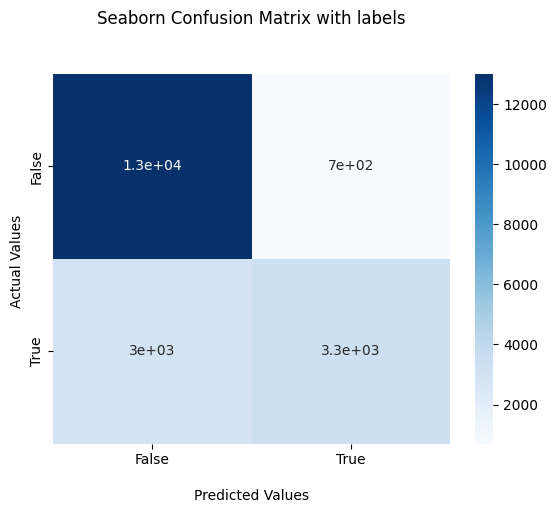

In [18]:
ax = sns.heatmap(cf_matrix, annot = True,  cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [20]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
autoencoder = Sequential()

In [21]:
adm1_codes_train.shape

(80032, 205)

In [22]:
#create neural network for the autoencoder
input_data = Input(shape=(adm1_codes_train.shape[1],))
encoder = Dense(164, activation='relu')(input_data)
encoder = Dense(128, activation='relu')(encoder)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dense(16, activation='relu')(encoder)
encoder = Dense(5, activation='relu')(encoder)
#encoder = Dense(5, activation='relu')(encoder)
#----------BOTTLENECK---------------------
#decoder = Dense(8, activation='relu')(encoder)
decoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(128, activation='relu')(decoder)
decoder = Dense(164, activation='relu')(decoder)
decoder = Dense(adm1_codes_train.shape[1], activation='sigmoid')(decoder)

autoencoder = Model(input_data, decoder)
autoencoder.compile(optimizer='sgd', loss='mse')

In [23]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 205)]             0         
                                                                 
 dense (Dense)               (None, 164)               33784     
                                                                 
 dense_1 (Dense)             (None, 128)               21120     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 5)                 85        
                                                                 
 dense_5 (Dense)             (None, 16)                96    

In [24]:
#fit the autoencoder
for i in range(0,5):
    noise = np.random.normal(loc=0.0, scale=0.1, size=adm1_codes_train.shape)
    adm1_codes_train_noisy = adm1_codes_train + noise
    noise = np.random.normal(loc=0.0, scale=0.1, size=adm1_codes_test.shape)
    adm1_codes_test_noisy = adm1_codes_test + noise
    autoencoder.fit(adm1_codes_train_noisy, adm1_codes_train, epochs=200, batch_size=1000, shuffle=True, validation_data=(adm1_codes_test_noisy, adm1_codes_test))

Epoch 1/200
81/81 [==============================] - 2s 14ms/step - loss: 0.2499 - val_loss: 0.2497
Epoch 2/200
81/81 [==============================] - 1s 10ms/step - loss: 0.2495 - val_loss: 0.2493
Epoch 3/200
81/81 [==============================] - 1s 10ms/step - loss: 0.2491 - val_loss: 0.2489
Epoch 4/200
81/81 [==============================] - 1s 10ms/step - loss: 0.2488 - val_loss: 0.2486
Epoch 5/200
81/81 [==============================] - 1s 10ms/step - loss: 0.2484 - val_loss: 0.2482
Epoch 6/200
81/81 [==============================] - 1s 10ms/step - loss: 0.2480 - val_loss: 0.2479
Epoch 7/200
81/81 [==============================] - 1s 11ms/step - loss: 0.2477 - val_loss: 0.2475
Epoch 8/200
81/81 [==============================] - 1s 11ms/step - loss: 0.2473 - val_loss: 0.2471
Epoch 9/200
81/81 [==============================] - 1s 11ms/step - loss: 0.2469 - val_loss: 0.2468
Epoch 10/200
81/81 [==============================] - 1s 11ms/step - loss: 0.2466 - val_loss: 0.2464

81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 163/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 164/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 165/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 166/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 167/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 168/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 169/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 170/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 171/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0

Epoch 43/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 44/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 45/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 46/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 47/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 48/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 49/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 50/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 51/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 52/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_los

Epoch 124/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 125/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 126/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 127/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 128/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 129/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 130/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 131/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 132/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 133/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049

81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 86/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 87/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 88/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 89/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 90/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 91/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 92/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 93/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 94/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epo

Epoch 46/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 47/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 48/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 49/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 50/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 51/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 52/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 53/200
81/81 [==============================] - 1s 12ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 54/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 55/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_los

Epoch 127/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 128/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 129/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 130/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 131/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 132/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 133/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 134/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 135/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 136/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049

81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 89/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 90/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 91/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 92/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 93/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 94/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 95/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 96/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 97/200
81/81 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0049
Epo

In [25]:
#use only encoder part to turn adm1 codes into separate attributes
encoder_net = Model(input_data, encoder)

X_train_encoded = encoder_net.predict(adm1_codes_train, batch_size=1)
X_test_encoded = encoder_net.predict(adm1_codes_test, batch_size=1)
adm1_codes_encoded = encoder_net.predict(adm1_codes, batch_size=1)

In [26]:
#verifying that there are 5 columns resulting from the autoencoder
adm1_codes_encoded.shape

(100040, 5)

In [27]:
df_complete.shape

(100040, 45)

In [28]:
#have a look at the encoded adm1 levels
pd.DataFrame(X_test_encoded)

,0,1,2,3,4
0,0.0,1.234249,2.113737,0.0,3.078864
1,0.0,1.398172,2.291194,0.0,3.344469
2,0.0,1.275943,2.205956,0.0,3.180590
3,0.0,1.083962,1.906782,0.0,2.769087
4,0.0,1.302785,2.069894,0.0,3.099730
...,...,...,...,...,...
20003,0.0,1.175822,2.007987,0.0,2.903824
20004,0.0,1.336921,2.193148,0.0,3.248803
20005,0.0,1.246624,2.087355,0.0,3.035533
20006,0.0,1.187395,2.042254,0.0,2.978177


In [29]:
#test how well the simple logistic regression model is doing with the encoded variables
lg.fit(X_train_encoded, adm1_codes_y_train)
lg.score(X_test_encoded,adm1_codes_y_test)

0.5310875649740104

In [30]:
#create another confusion matrix to ensure that not only the majority class is predicted
adm1_codes_y_pred_new = lg.predict(X_test_encoded)
cf_matrix = confusion_matrix(adm1_codes_y_pred_new, adm1_codes_y_test)

In [31]:
cf_matrix

array([[8665, 2041],
       [7341, 1961]], dtype=int64)

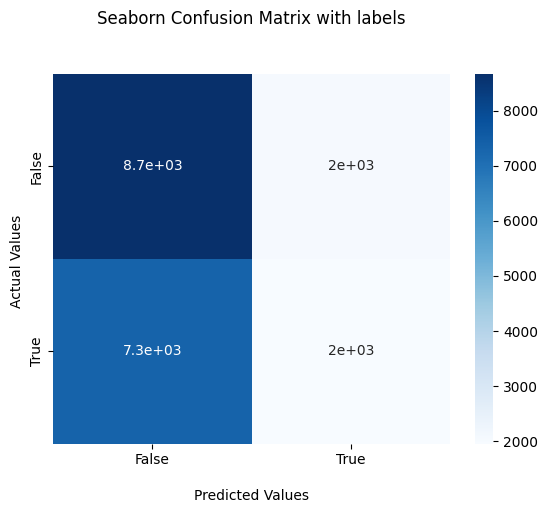

In [32]:
ax = sns.heatmap(cf_matrix, annot = True,  cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [33]:
#join the new ADM1 compressed dimensions withe the one-hot-encoded ones and retrain the logistic regression
df_all_adm1 = pd.concat([adm1_codes, pd.DataFrame(adm1_codes_encoded)], axis = 1)
df_all_adm1
df_all_adm1_train, df_all_adm1_test, df_all_adm1_y_train, df_all_adm1_y_test = train_test_split(df_all_adm1, adm1_codes_y, test_size=0.2, random_state=42)
lg.fit(df_all_adm1_train, df_all_adm1_y_train)
print(lg.score(df_all_adm1_test , df_all_adm1_y_test))
print(lg.score(df_all_adm1_train , df_all_adm1_y_train))

C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.8115753698520591
0.8109006397441023


C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

In [ ]:
#add the newly encoded adm1 codes to the dataframe
df_complete = df_complete.reset_index(drop=True)
df_complete = df_complete.join(pd.DataFrame(adm1_codes_encoded))

In [ ]:
df_complete

In [ ]:
#drop all non-numeric columns except for the date field 
df_complete.drop(columns = ["ActionGeo_ADM1Code", "Country Code", "country", "iso_code"], inplace = True)

In [ ]:
df_complete3 = df_complete.copy()

In [ ]:
#convert date dimension into numeric field 
df_complete3['InsertedDate'] = pd.to_datetime(df_complete3['MonthYear'], format='%Y%m')
df_complete3['InsertedDate']

In [ ]:
##experiment with date feature
list_1 = list(df_complete3['InsertedDate'])
minimum_list1 = min(list_1)

# Get the list with seconds since earliest event
list_2 = [(i - minimum_list1).total_seconds() for i in list_1]
# Normalize data so it lies between 0 and 1
#list_3 = [i/max(list_2) for i in list_2]
#print(date_features)

In [ ]:
df_complete3['MonthYear_New'] = list_2

In [ ]:
df_complete3.columns

In [ ]:
df_complete3.drop(columns =['InsertedDate', 'year', 'MonthYear'], inplace = True )

### 5) Checking for Correlations

In [7]:
#calculating correlations with all predictors to the target variable
df_corr = df_complete3.corrwith(df_complete3['number of conflicts'])
df_corr = df_corr.reset_index(drop = False)

In [8]:
#check for missing values 
na_corr = list(df_corr[df_corr[0].isna() == True]['index'])

In [ ]:
#before we check maximum and minimum correlations, we exclude the target variable itself, which would have a perfect correlation of 1
df_corr = df_corr[df_corr['index'] != 'number of conflicts']

In [ ]:
#checking the maximum correlation
df_corr.max()

In [ ]:
#checking the minimzm correlation
df_corr.min()

In [ ]:
#export dataframe for the next notebook
df_complete3.to_pickle(path = "df_complete3_v3.pickle")